In [1]:
import numpy as np

from modules.helper_functions_tsp import ( 
    read_file_name, validate_distance_array, find_problem_size, cost_fn_fact, 
    read_index, hot_start, convert_bit_string_to_cycle, hot_start_list_to_string,
    update_parameters_using_gradient, define_parameters, create_initial_rotations,
    bind_weights, vqc_circuit, cost_func_evaluate)

from modules.graph_functions import parameter_graph, cost_graph_multi

import copy
import time

In [ ]:
from modules.config import (
    CONTROL_FILE, ENCODING, GRAPH_DIRECTORY, LOCATIONS, ROTATIONS, SHOTS,
    MODE, ITERATIONS, PRINT_FREQUENCY, GRAY, HOT_START,
    VERBOSE, GRADIENT_TYPE, S, ETA, ALPHA, GAMMA, C,    
    DATA_SOURCES, CHANGE_EACH_PARAMETER, PLOT_PARAMETER_EVALUATION,
    SLICES, DECODING_FORMULATION)

## Read in the control file
The executions are controlled by a CSV parameter file in the control directory

In [3]:
control_dict = read_index(CONTROL_FILE, ENCODING)
print(control_dict)

{0: {'id': '0', 'locations': '5', 'mode': '1', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}, 1: {'id': '1', 'locations': '5', 'mode': '2', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}}


From the number of locations visited find the qubits and longest binary string.

In [4]:
qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')

There are 26 qubits needed for 11 locations in the new formulation.


Data sources are held locally to avoid downstream dependencies.  Read the data, and print out the filename and best distance held in the data.

In [5]:
filename = read_file_name(LOCATIONS, DATA_SOURCES)
best_dist = DATA_SOURCES[LOCATIONS]['best']
print(f'Data will be read from filename {filename}.  It is known that the shortest distance is {best_dist}.')

Data will be read from filename data/dg11_d.txt.  It is known that the shortest distance is 253.


Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [6]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

Define the VQC circuits with appropriate parameters, and draw the circuit.

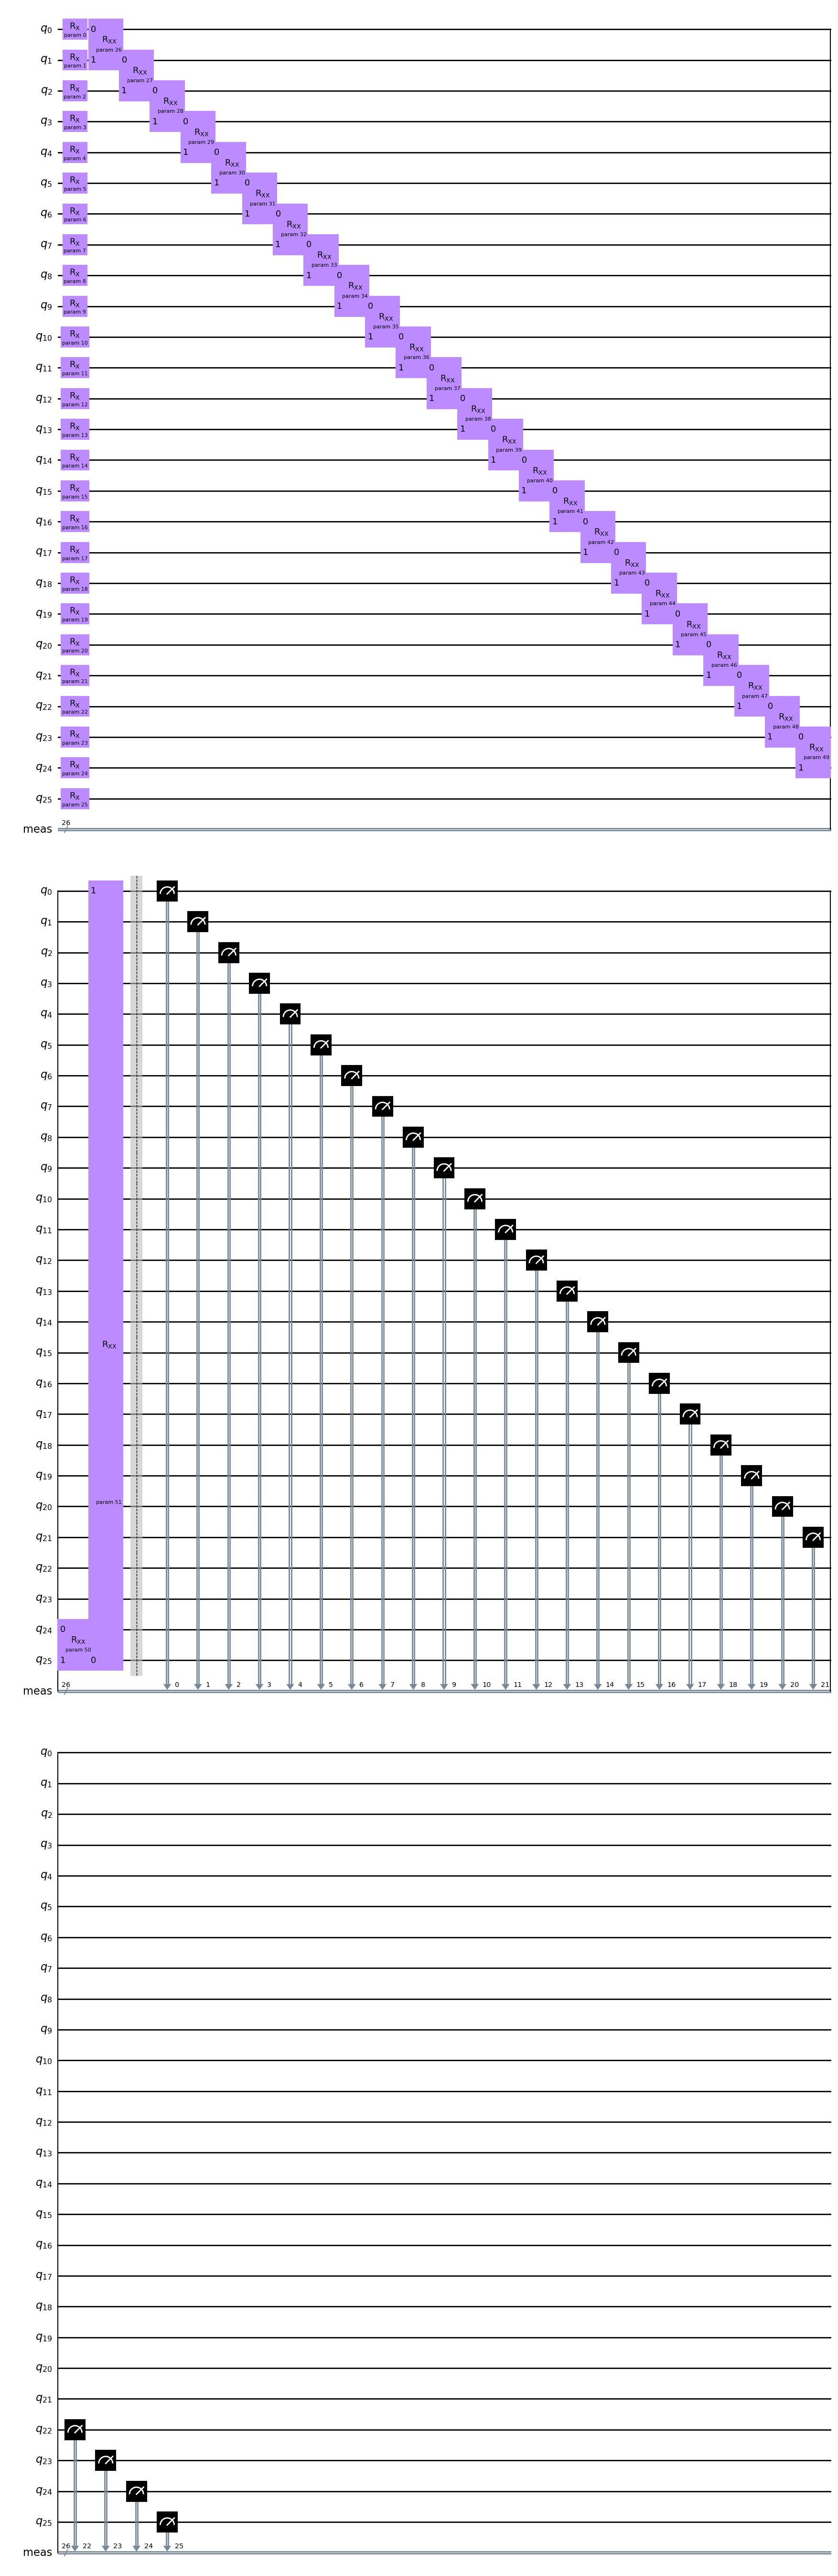

In [7]:
params = define_parameters(qubits, MODE)
qc = vqc_circuit(qubits, params, MODE)
qc.draw("mpl", style="clifford")

In [8]:
cost_fn = cost_fn_fact(LOCATIONS,distance_array, GRAY, method = DECODING_FORMULATION)

Iterate over the control parameters and do one experiment for each one of them.

Create random initial rotations, and bind these to the parameters in a new circuit `bc`.

The hot start location list is [0, 8, 7, 2, 10, 1, 4, 3, 5, 9, 6]
This is equivalent to a binary list: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
The hot start distance is 299.0, compared to a best distance of 253.
The initial parameters (weights) are [3.14159265 0.         3.14159265 3.14159265 3.14159265 3.14159265
 0.         0.         0.         0.         3.14159265 0.
 3.14159265 0.         3.14159265 3.14159265 3.14159265 3.14159265
 3.14159265 3.14159265 3.14159265 3.14159265 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


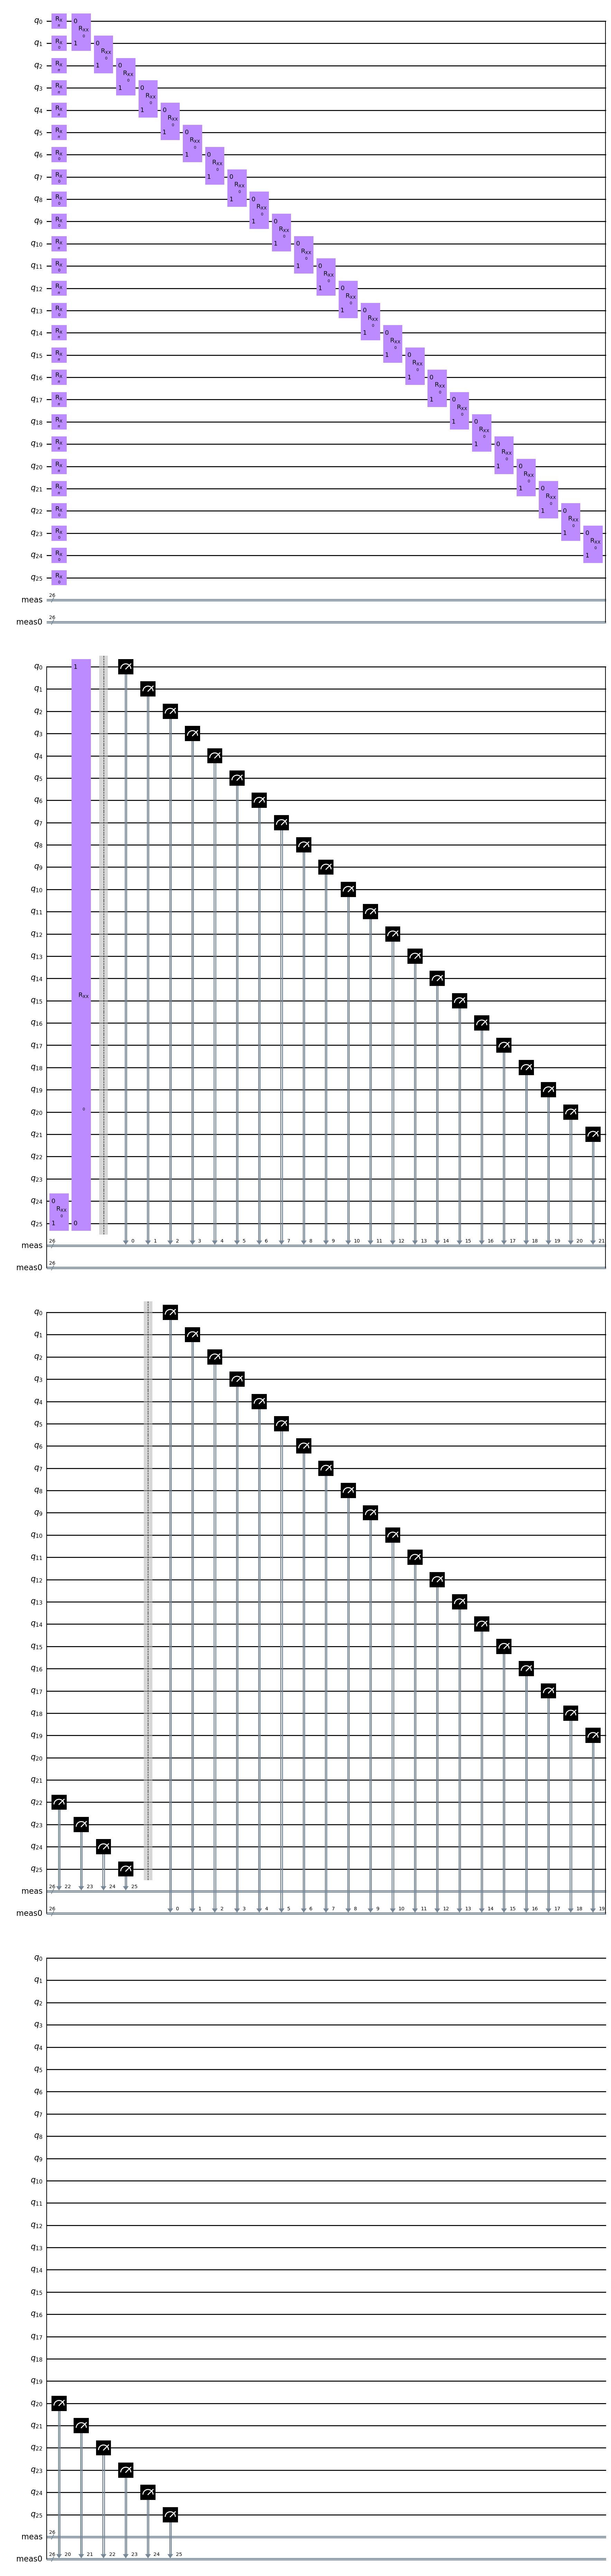

In [9]:
if HOT_START:
    hot_start_list = hot_start(distance_array, LOCATIONS)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY, DECODING_FORMULATION)
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    distance = cost_fn(bin_hot_start_list)
    print(f'The hot start distance is {distance}, compared to a best distance of {best_dist}.')
    init_rots = create_initial_rotations(qubits, MODE, bin_hot_start_list, HOT_START)
else:
    init_rots = create_initial_rotations(qubits, MODE)
print(f'The initial parameters (weights) are {init_rots}')
bc = bind_weights(params, init_rots, qc)
bc.measure_all()
bc.draw("mpl", style="clifford")

In [10]:
cost_start, lowest_to_date, _ = cost_func_evaluate(cost_fn, bc, shots=SHOTS, average_slice=SLICES[0], verbose=VERBOSE)
print(f'For the starting circuit the average cost is {cost_start:.1f} and the lowest cost is {lowest_to_date:.1f}')

For the starting circuit the average cost is 299.0 and the lowest cost is 299.0


Next we test the impact of varying each parameter in turn on the average cost.

In [11]:
#only run for one slice.
average_slice = SLICES[0]
if CHANGE_EACH_PARAMETER:
    param_values = np.array([(i * 2 * np.pi) / (ROTATIONS-1) for i in range(ROTATIONS)])
    cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
    if VERBOSE:
        print(f'init_rots = {init_rots}')
    #need deep copy in case init_rots is changed
    for i in range(2*qubits):
        rots = copy.deepcopy(init_rots)
        if VERBOSE:
            print(f'Processing parameter {i}')
            print(f'rots = {rots}, init_rots = {init_rots}')
        cost_list, lowest_list, sliced_cost_list  = [], [], []
        for angle in param_values:
            rots[i] = angle
            bc = bind_weights(params, rots, qc)
            sliced_cost, _ , _ = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=average_slice, verbose=VERBOSE)
            cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=1, verbose=VERBOSE)
            route_list = convert_bit_string_to_cycle(lowest_energy_bit_string, LOCATIONS, gray=GRAY, method=DECODING_FORMULATION)
            cost_list.append(cost)
            lowest_list.append(lowest)
            sliced_cost_list.append(sliced_cost)
            if VERBOSE:
                print(f'For angle {angle} the cost is {cost}, the lowest cost found is {lowest}')
                print(f'The full parameter vector is {rots}')
                print(f'the lowest energy bit string is {lowest_energy_bit_string} and this corresponds to a route of {route_list}')
                print(f'The average is {cost} without slicing, and {sliced_cost} with slicing')
        cost_list_all.append(cost_list)
        lowest_list_all.append(lowest_list)     
        sliced_cost_list_all.append(sliced_cost_list)
    cost_fn.print_cache_stats
    cost_fn.clear_cache() #need to clear cache so statistics are not cumulative

In [ ]:
if CHANGE_EACH_PARAMETER:
    filename = GRAPH_DIRECTORY + 'Parameter_values'
    main_title = f'Av. and lowest energy (distance) found by changing each parameter in turn. Slices = {SLICES[0]}'
    sub_title = 'Parameter '
    x_label = 'Gate rotation in Radians'
    param_names = [i for i in range(2*qubits)]
    cost_graph_multi(filename, param_names, param_values, 
                    cost_list_all, lowest_list_all, sliced_cost_list_all, 
                    best_dist, main_title, sub_title, x_label)
    

In [13]:
if PLOT_PARAMETER_EVALUATION:
    average_slice = SLICES[0]
    #only do for one slice
    index_l, sliced_l, lowest_l, gradient_l, average_l, parameter_l = \
    update_parameters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                    print_frequency=PRINT_FREQUENCY, params=params,
                                    rots=init_rots,  
                                    cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                    eta=ETA, average_slice=average_slice, gray=GRAY, 
                                    verbose=VERBOSE, gradient_type=GRADIENT_TYPE,
                                    alpha=ALPHA, gamma=GAMMA, c=C,
                                    method=DECODING_FORMULATION
                                    )
    cost_fn.print_cache_stats
    cost_fn.clear_cache() #need to clear cache so statistics are not cumulative

In [14]:
if PLOT_PARAMETER_EVALUATION:
    legend = [params[i].name for i in range(len(params))] 
    filename = GRAPH_DIRECTORY+f'Evolution of parameters with iterations'
    parameter_graph(filename, index_l, parameter_l, legend)

Do one run and time

In [ ]:
#average_slice = SLICES[0]
#average_list_all = [average_l]
#lowest_list_all = [lowest_l]
#sliced_list_all = [sliced_l]
#title = f'Average and lowest distances with average slice = {average_slice}'
#filename = GRAPH_DIRECTORY+title+'.png'
#parameter_list = [average_slice]
#x_label = 'Iteration'
#cost_graph_multi(filename, parameter_list, index_l, 
#                average_list_all, lowest_list_all, sliced_list_all,
#                best_dist, main_title=title, x_label=x_label, figsize = (4,4))
#cost_fn.print_cache_stats
#cost_fn.clear_cache() #need to clear cache so statistics are not cumulative

In [ ]:
t0 = time.time()
av_cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
rots = copy.deepcopy(init_rots)
for slice in SLICES:
    index_list, sliced_list, lowest_list, _ , average_list, _ = \
    update_parameters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                    print_frequency=PRINT_FREQUENCY, params=params,
                                    rots=rots,  
                                    cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                    eta=ETA, average_slice=slice, gray=GRAY, 
                                    verbose=VERBOSE, gradient_type=GRADIENT_TYPE,
                                    alpha=ALPHA, gamma=GAMMA, c=C,
                                    method=DECODING_FORMULATION)
    av_cost_list_all.append(average_list)
    lowest_list_all.append(lowest_list)
    sliced_cost_list_all.append(sliced_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
        

For iteration 0 using the best 100 percent of the results
The average cost from the sample is 299.000 and the top-sliced average of the best results is 299.000
The lowest cost from the sample is 299.000
The lowest cost to date is 299.000 corresponding to bit string [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1] 
and route [0, 8, 7, 2, 10, 1, 4, 3, 5, 9, 6]
For iteration 50 using the best 100 percent of the results
The average cost from the sample is 334.767 and the top-sliced average of the best results is 334.222
The lowest cost from the sample is 264.000
The lowest cost to date is 256.000 corresponding to bit string [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0] 
and route [0, 8, 7, 2, 10, 1, 6, 5, 9, 3, 4]
For iteration 100 using the best 100 percent of the results
The average cost from the sample is 325.442 and the top-sliced average of the best results is 325.290
The lowest cost from the sample is 259.000
The lowest c

KeyboardInterrupt: 

Items in cache = 128
cache_hit = 38353
cache_miss = 128
cache_hit_rate = 0.997


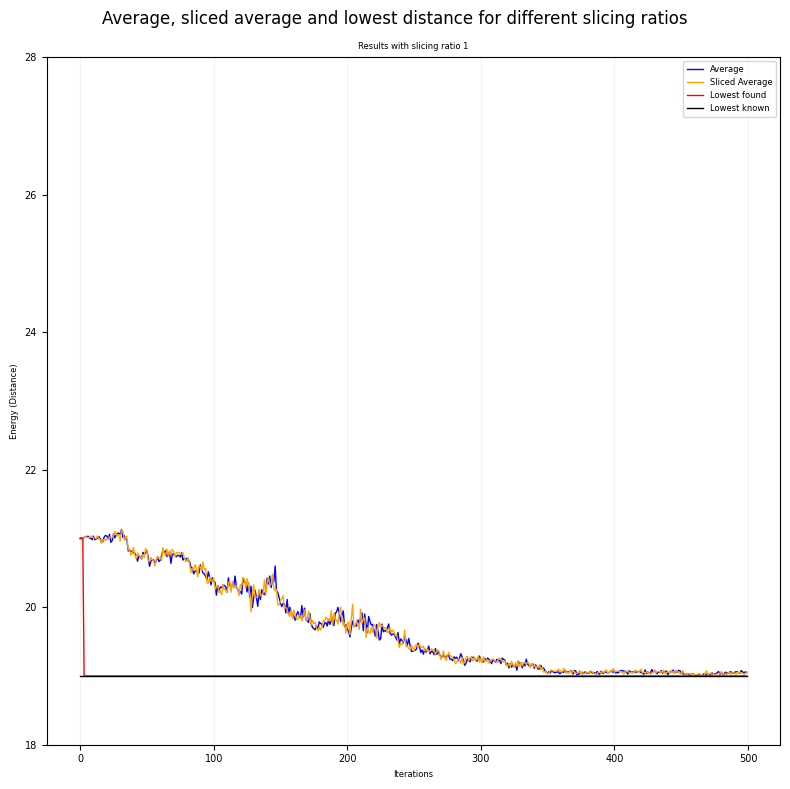

In [ ]:
title = 'Average, sliced average and lowest distance for different slicing ratios'
filename = GRAPH_DIRECTORY+title+'.png'
sub_title = 'Results with slicing ratio '
x_label = 'Iterations'
cost_graph_multi(filename, slices, index_list, av_cost_list_all, 
                lowest_list_all, sliced_cost_list_all, 
                best_dist, title, sub_title,
                x_label
                )
cost_fn.print_cache_stats
cost_fn.clear_cache() #need to clear cache so statistics are not cumulative